In [1]:
import pandas as pd 
from functools import reduce
import pickle
import time
from collections import defaultdict
import os
import numpy as np
import matplotlib.pyplot as plt

block_list = [400000]

df = pd.read_pickle('../../pickles/df/400000.pickle')

# New columns for number of input and output transaction ids
df['num_txo'] = df.groupby('id_t')['id_txo_out'].transform('nunique')
df['num_txi'] = df.groupby('id_t')['id_txi'].transform('nunique')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#CHANGE LATER TO QUERY DATABASE INSTEAD

def tx_from_iadr(iadr):
    return set(df['id_t'][df["iadr"] == iadr])

def tx_from_oadr(oadr):
    return set(df['id_t'][df["oadr"] == oadr])

def iadrs_from_tx(id_t):
    return set(df['iadr'][df["id_t"] == id_t])

def oadrs_from_tx(id_t):
    return set(df['oadr'][df["id_t"] == id_t])

def block_from_tx(id_t):
    return set(df['block_no'][df["id_t"] == id_t])

class Addr:
    def __init__(self):
        self.adr = None
        self.sending_tx = set()
        self.receiving_tx = set()
        self.blocks = set()
        self.adr_rec_from = set()
        self.adr_sent_to = set()
        self.iadr_shared = set()
        self.oadr_shared = set()

adrs = []
already_seen_adr = set()

for iadr in set(df.iadr):
    a = Addr()
    a.adr = iadr
    st = tx_from_iadr(iadr)
    rt = tx_from_oadr(iadr)
    a.sending_tx.update(st)
    a.receiving_tx.update(rt)
    for t in st:
        a.adr_sent_to.update(oadrs_from_tx(t))
        shared = iadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.iadr_shared.update(shared)
    for t in rt:
        a.adr_rec_from.update(iadrs_from_tx(t))
        shared = oadrs_from_tx(t)
        shared.remove(iadr)
        if shared:
            a.oadr_shared.update(shared)
    already_seen_adr.add(iadr)
    adrs.append(a)
    
for oadr in set(df.oadr):
    if oadr not in already_seen_adr:
        a = Addr()
        a.adr = oadr
        rt = tx_from_oadr(oadr)
        a.receiving_tx.update(rt)
        for t in rt:
            a.adr_rec_from.update(iadrs_from_tx(t))
            shared = oadrs_from_tx(t)
            shared.remove(oadr)
            if shared:
                a.oadr_shared.update(shared)
        already_seen_adr.add(oadr) 
        adrs.append(a)
        
#WHICH ADDRS IN HAVE TRANSACTED WITH EACH OTHER
edges = []
for adr in adrs:
    a_s=adr.adr_sent_to
    a_r=adr.adr_rec_from
    if(a_s):
        for sadr in a_s:
            edges.append((adr.adr,sadr)) 
    if(a_r):
        for radr in a_r:
            edges.append((radr,adr.adr))

# _num_send_tx = [len(_adr.sending_tx) for _adr in adrs]
# _num_rec_tx = [len(_adr.receiving_tx) for _adr in adrs]

# adr_df = pd.DataFrame(_adrs,columns=['addrs'])

# adr_df['num_send_tx'] = _num_send_tx
# adr_df['num_rec_tx'] = _num_rec_tx
# adr_df['category'] = 'unknown'

#Max Sent
#Min Sent
#Max Rec
#Min_Rec
#Total_Sent
#Total_Rec

In [3]:
# addr input features
addr_input_df = df.groupby('iadr').agg({
    'id_txo_out': 'nunique', #Num unique times paid out
    'oadr':'nunique', #Num of unique out addresses paid out
    'id_t': 'nunique', #Num Txs involved in
    'input_val': ['max', 'min']
})

addr_input_df.columns = ['_'.join(col) for col in addr_input_df.columns]

addr_input_df.rename(columns={
    'id_txo_out_nunique': 'unique_sent', #Num of unique outputs coming from the transaction
    'oadr_nunique': 'unique_sent_adr',
    'id_t_nunique': 'num_send_tx',
    'input_val_max': 'max_sent',
    'input_val_min': 'min_sent'
}, inplace=True)

addr_input_df['total_sent'] = (df['input_val'] / df['num_txo']).groupby(df['iadr']).sum()

# addr input features
addr_out_df = df.groupby('oadr').agg({
    'id_txi': 'nunique', #Num unique times paid in
    'iadr': 'nunique', #Num of unique in addresses paid this address
    'id_t': 'nunique', #Num Txs involved in
    'output_val': ['max', 'min']
})

addr_out_df.columns = ['_'.join(col) for col in addr_out_df.columns]

addr_out_df.rename(columns={
    'id_txi_nunique': 'unique_rec',
    'iadr_nunique': 'unique_rec_adr',
    'id_t_nunique': 'num_receiving_tx',
    'output_val_max': 'max_rec',
    'output_val_min': 'min_rec'
}, inplace=True)

addr_out_df['total_rec'] = (df['output_val'] / df['num_txi']).groupby(df['oadr']).sum()

adr_df = addr_input_df.merge(addr_out_df, how='outer', left_index=True, right_index=True)

adr_df.fillna(0, inplace=True)
#Add column to indicate labelled users
adr_df["category"] = "unknown"

/homes/ac2917/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [4]:
_adrs = [_adr.adr for _adr in adrs]
_num_iadr_shared = [len(_adr.iadr_shared) for _adr in adrs]
_num_oadr_shared = [len(_adr.oadr_shared) for _adr in adrs]

for i,a in enumerate(_adrs):
    adr_df.loc[a, 'num_iadr_shared'] = _num_iadr_shared[i]
    adr_df.loc[a, 'num_oadr_shared'] = _num_oadr_shared[i]

In [5]:
adr_df

unique_sent   max_sent   min_sent  \
0                                           1.0   0.000000   0.000000   
1111111111111111111114oLvT2                 0.0   0.000000   0.000000   
1127n97VdXgdPJCY1BfcSHahDoyQ3VUMt9          0.0   0.000000   0.000000   
112Mk5dWHsCRT1mzxQgzWPFqoV5EneR8kM          1.0   0.025000   0.025000   
112V8cEeQa4HF7pTNw4ehpWNnDJtFz3VeK          0.0   0.000000   0.000000   
112guu3fDfo8s6cC2LoApJdLbMNvx63dsb          1.0   8.702000   8.702000   
112uT4y5JyrsSqPS8cQ6nTbH7aqH5NdX4E          2.0   0.594000   0.594000   
112vuRrr82QsR34ZkHD3ZR5s8CDQPP3bvS          0.0   0.000000   0.000000   
1132gTtFtZQTjvpvE4fXPZhTmWPwMaA2r8          2.0   0.000179   0.000179   
113nMsoy9XjmSC9GBFhsqTUtysZxkkZr32          0.0   0.000000   0.000000   
113x7dNc9TWJ5PtknaaJCfq1Zkv4WBtMRa          2.0   0.001200   0.001200   
1144mPGazDzYdma1YbQ4kFJSHyqg8MNGzu          0.0   0.000000   0.000000   
114Nh7UYer2Qqn6pqs1N7D5bvtKMJRwrVc          0.0   0.000000   0.000000   
114ev4qj9e4EMWkZeyQCqUNcXaJExhb3hs          0.0   0.000000   0.000000   
114gDgFMcFRPRnTaifBjuPen3ZJQox3WuJ          2.0   0.481499   0.481499   
1153kFncswjgNZwqTW5bvxpRB7b2R5gona          0.0   0.000000   0.000000   
1158mZ1LfWVfNcF3Z368ZGi3T4gLFkXwht          2.0   0.023832   0.000375   
115GjoYLxnEw6MHiqKnxNxZU5xLqbVUiTn          1.0   0.043200   0.000100   
115NJTTdkDRhicZQX8sK6pthhnZtizhcCq         21.0  10.000000  10.000000   
115iad676RDNs23HpQLGbtyiWNBkEKGgxU          1.0   0.000302   0.000302   
1161QUHNdBCkjB5iYrhyHm7NTR3y8Bj9zP          0.0   0.000000   0.000000   
11STGJF9g2itAeaNqnpeYb7m5Gqg7NQDh           0.0   0.000000   0.000000   
121NdBy658emXSMFEDCPT5TmzrVH3CxGSF          3.0   0.000457   0.000457   
122G7b5D9rTF5xKwM7yxoGnGMWzea1ofTw          0.0   0.000000   0.000000   
122pviSkVE2zDdELuoceKoSp43LSh5EgjH          1.0   0.837371   0.837371   
12364CVaLduRLA5hwx4SH7pQevyfR3xBoP          0.0   0.000000   0.000000   
1239fLdSqKuay6TR7A3ey6azKxzcktM27n          1.0   0.000098   0.000098   
123AZbQmBMczN2YEoQ4C91yw5VwJLLdVr5          1.0   0.268000   0.268000   
123J1WHv6nUqcrtTWHuzsDcCY4xfkKiFLK          2.0   0.157110   0.157110   
123JPkxGWKzcKrtKKgWQwhQqtdGRSUJ8hS          2.0   0.001182   0.001182   
...                                         ...        ...        ...   
1quUqEfXiiw3hQ5N49kvwCAbhLcZJTqZV           2.0   0.001757   0.001757   
1rsVk6zFtJVLehnsjxQfBmYUyEZ6e22oX           0.0   0.000000   0.000000   
1rzmVEYqGAABBLF43h1b81dFQ9mL5WMHU           2.0   0.000087   0.000087   
1sYCzFRXHBPPF8SXP9yQeKbQprvJCdW9V           2.0  18.541100  18.541100   
1t5Kn3z3iiW6yeekhZhGoMYc1H97gHaKi           0.0   0.000000   0.000000   
1t9FB9EDSotQNTGzPxef3WMtAW4MSnJ7K           0.0   0.000000   0.000000   
1tVSALodwByH1uHgzyDWqzxHYzP3AK1Go           1.0   0.049600   0.049600   
1tgyDyTNeNWeErehhuymq6XoFnGRc4jub           0.0   0.000000   0.000000   
1tkjtG7ZkhhxHYNgmvxaWxMrvLxdyQBi3           1.0   1.993700   1.953690   
1trF5wcUJoF3uxVeGEBC3b7NxqpNc4M78           2.0   0.001186   0.001186   
1tv7KV8koJy2QAgU18fB77HCppWTw3ppe           2.0   0.006895   0.006895   
1u1UquBzLQeCWqbXYAunPMcGRxjqfahke           1.0  11.980600  11.980600   
1uonkmcfzoDR6gQERdpfhHdpnh7x4YvWW           2.0   0.113000   0.052000   
1v9tJDQh3VEjHa5LWDf6FxMjB7DcTauis           2.0   0.112820   0.112820   
1vFLTqgZAnivJmUR1KnN7HjnMZA7k2U9W          13.0   0.010687   0.010687   
1vM9dZspqsL5cTHHMSMHUdfqjXDBsFcXi           2.0   0.265000   0.265000   
1vNyMbLSym7YyFEyUf5sPjWnbQGyQTgYv           2.0   0.000951   0.000951   
1vaaJZ6n2DHMG7cDichyPHVg19qWoTRsC           0.0   0.000000   0.000000   
1vbvqxDr9QeX3p9LskU2NCyUK2Bczye26           2.0   0.065335   0.065335   
1vjgafSpkA78eLoNBYmaP893xq6gnAXRy           0.0   0.000000   0.000000   
1vmznuej5MzGC4WRycngk9bzMEsAsDiAp           2.0   0.203380   0.203380   
1wCRmTCmw24SxThf3MG9vEMo6eRjpyaPo           0.0   0.000000   0.000000   
1xVcpRW1E7NfAHAzXTXV52SgFD7zjHyyW           0.0   0.000000   0.000000   
1xbZF4pEs3jvtM6D9Pbef

## Tag addresses

In [7]:
#Dictionary structure -
#'Address': 'Category'
categories = ['exchanges','gambling','pool']
dic_addrlabels = defaultdict(set)
starttime = time.time()

all_adr = set(df.iadr).union(set(df.oadr))
for category in categories:
    #for block in range(first_block,last_block+1,1):
    category_df = pd.read_pickle('../../pickles/categories/{}.pickle'.format(category))
    x = all_adr.intersection(set(category_df.address))
    if x:
        for adr in x:
            dic_addrlabels[adr].add(category)
print("Total time to dict:", time.time()-starttime)

Total time to dict: 4.4784910678863525


In [8]:
for key in dic_addrlabels:
    adr_df.loc[key, 'category'] = dic_addrlabels[key] #label[cat.pop()]  
adr_df = adr_df.dropna(axis=0,how='any')

In [ ]:
dic_addrlabels

## Class Imbalance

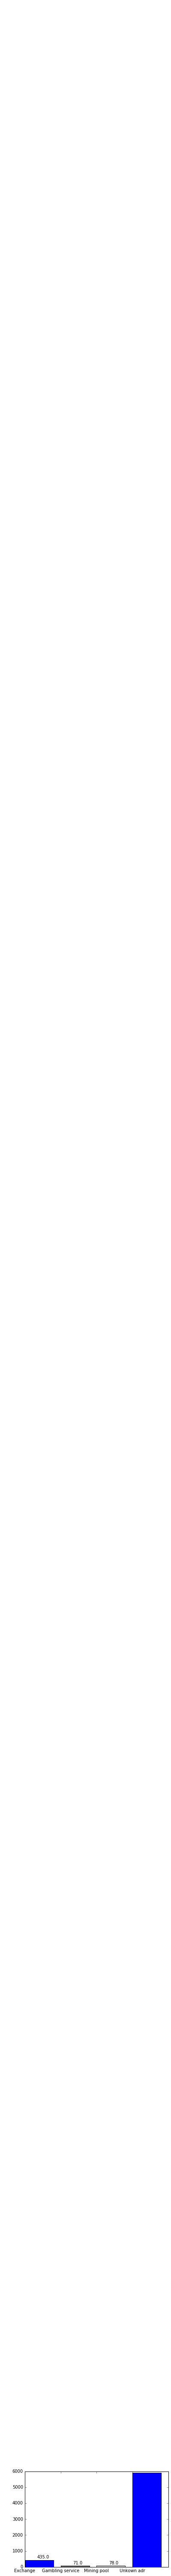

In [9]:
exchanges = np.sum(adr_df["category"] == 'exchanges') # or just sum over column, bc its binary
gambling = np.sum(adr_df["category"] == 'gambling') # or just sum over column, bc its binary
pool = np.sum(adr_df["category"] == 'pool')
unknown = np.sum(adr_df["category"] == 'unknown')

fig, ax = plt.subplots()
exchanges, gambling, pool,unknown = plt.bar((0,1,2,3), (exchanges, gambling, pool,unknown))
gambling.set_facecolor('dimgray')
pool.set_facecolor('lightgray')
ax.set_xticks((0,1,2,3))
for p in (ax.patches):
    ax.annotate(str(p.get_height()), (p.get_x()+0.34, p.get_height() +100), fontsize=10)
ax.set_xticklabels(['Exchange', 'Gambling service', 'Mining pool', 'Unkown adr'])

In [ ]:
data_correlation = adr_df.corr(method='spearman')
print("correlation: ")
data_correlation.style.format("{:.2}").background_gradient(cmap=plt.cm.Greens, axis=1)

In [ ]:
data_correlation[(abs(data_correlation) > 0.8) & ( data_correlation != 1.0)].dropna(how="all", axis=(0,1))

In [ ]:
indices = data_correlation.index
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(data_correlation, vmin=-1, vmax=1, cmap=plt.cm.Greens)
fig.colorbar(cax)
ticks = np.arange(0,len(indices),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.xticks(rotation=90)
ax.set_xticklabels(indices, fontsize=8)
ax.set_yticklabels(indices, fontsize=8)
plt.grid()
plt.savefig("correlation_matrix.pdf")

## Unsupervised

In [ ]:
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
sns.set(style="whitegrid", color_codes=True)
import imblearn

from sklearn import preprocessing
from sklearn import cluster
import scipy as sp
from sklearn.metrics import silhouette_score

In [ ]:
#Normalize data
Y = pd.DataFrame(adr_df['category'])
adr_df_x = adr_df.drop(['category'], axis=1)
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
scaled_x = scaler.fit_transform(adr_df_x)

X = pd.DataFrame(scaled_x, columns=adr_df_x.columns, index=adr_df_x.index)

In [ ]:
#Principal Component Analysis - DIMENSIONALITY REDUCTION
pca = sklearn.decomposition.PCA()
plot_columns = pca.fit_transform(X)   
#cmap = matplotlib.colors.ListedColormap(colors),
plt.scatter(x=plot_columns[:,0],y=plot_columns[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


In [ ]:
clusters = range(2,10)
meandist=[]
inertias = []
ss = []

for k in clusters:
    model = cluster.KMeans(n_clusters = k)
    model.fit(X)
    meandist.append(sum(np.min(sp.spatial.distance.cdist(X,model.cluster_centers_,'euclidean'),axis=1))/X.shape[0])
    #distorsions.append(model.inertia_) 
    ss.append(silhouette_score(X, model.labels_))

plt.plot(clusters, meandist, '-o')
plt.title('Selecting k with the Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')

# plt.subplot(1, 2, 2)
# plt.plot(clusters, distorsions, '-o')
# plt.title('Selecting k with the Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('Model inertia')

plt.show
plt.grid(True)

In [ ]:
def pca_and_plot(X_train, y_train):
    pca = sklearn.decomposition.PCA(n_components=2)
    principalComponents = pca.fit_transform(X_train)
    y_df = pd.DataFrame(data = y_train, columns=["category"])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y_df], axis=1)
    # 2d plot: 
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA')
    targets = [0,1,2,3]
    colors = ['gray', '#127161', 'red','black']
    markers = ['^','^','^','^']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['category'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , marker=markers[target]
                   , s = 200)
    ax.legend(targets)
    ax.grid()

In [ ]:
X.shape

In [ ]:
X[_Y == 0].shape

In [ ]:
X_balanced = []
y_balanced = []

for i in range(4):
    X_c_sample = X[_Y == i].values
    random_indices = np.random.choice(np.arange(X_c_sample.shape[0]), size=71)
    X_balanced.append(X_c_sample[random_indices])
    y_balanced.append(np.ones(71)*i)

In [ ]:
X_balanced = np.array(X_balanced)
y_balanced = np.array(y_balanced)

In [ ]:
y_balanced.shape

In [ ]:
X_balanced = X_balanced.reshape((X_balanced.shape[0]*X_balanced.shape[1], X_balanced.shape[2]))
y_balanced = y_balanced.reshape((y_balanced.shape[0]*y_balanced.shape[1]))

In [ ]:
from sklearn.preprocessing import LabelEncoder 
_Y = LabelEncoder().fit_transform(Y.category)
pca_and_plot(X_balanced, y_balanced)

In [ ]:
def tsne_and_plot(X_train, y_train):
    pca = sklearn.manifold.TSNE()
    principalComponents = pca.fit_transform(X_train, y_train)
    y_df = pd.DataFrame(data = y_train, columns=["category"])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, y_df], axis=1)
    # 2d plot: 
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title('2 component PCA')
    targets = [0,1,2,3]
    colors = ['gray', '#127161', 'red','black']
    markers = ['^','^','^','^']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['category'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , marker=markers[target]
                   , s = 200)
    ax.legend(targets)
    ax.grid()

In [ ]:
tsne_and_plot(X_train=X_balanced, y_train=y_balanced)